In [1]:
#importing libraries
import pandas as pd
import numpy as np
import tensorflow as tf
import random
import functools
import math
import livelossplot
import pickle
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import numpy as np
from tqdm import tqdm
from Utils.helper import *
from Utils.sample_squads import *

In [2]:
thresh = 3
def my_autopct(pct):
    return ('%.2f' % pct)+" %" if pct >= thresh else ''

In [3]:
model_inn_1 = tf.keras.models.load_model('Models\Inn1-HeavyDense-ep20to50\cp-0029.h5')
model_inn_2 = tf.keras.models.load_model('Models\Inn2-HeavyDenseRequired-ep30to50\cp-0016.h5')

## Innings 1

In [4]:
inn1_df = pd.DataFrame(columns=BF_Cols)
# inn1 = Innings(RCB_Squad[0], CSK_Squad[1], CSK_Squad[0][0], RCB_Pitch, 1, inn1_df)
# target = inn1.simulate_inning(model_inn_1)
with open("Evaluation/best_first_innings.pkl", "rb") as fp:
    inn1 = pickle.load(fp)["inn1"]
target = inn1.Runs + 1
display_batting_table(inn1)

Royal Challengers Bangalore  :  190 / 6  in  20 . 0
Extras: 14



,Batsman,Runs,Fours,Sixes,Balls Faced,Dismissal Type,Dismissed By
0,PA Patel,4,1,0,10,Caught,SN Thakur
1,V Kohli,24,2,0,21,Caught,RA Jadeja
2,AB de Villiers,27,5,0,21,Bowled,Imran Tahir
3,M Ali,7,0,1,4,Run Out,-
4,S Hetmyer,46,3,3,32,Caught,DJ Bravo
5,S Dube,62,5,4,29,Bowled,DL Chahar
6,C de Grandhomme,6,1,0,4,Not Out,-
7,N Saini,0,0,0,0,Not Out,-
8,YS Chahal,-,-,-,-,-,-
9,UT Yadav,-,-,-,-,-,-


,Bowler,Runs Conceded,Wickets Taken,Overs,Batsman Names
0,SN Thakur,48,1,4.0,PA Patel
1,Imran Tahir,32,1,4.0,AB de Villiers
2,RA Jadeja,28,1,4.0,V Kohli
3,DL Chahar,38,1,4.0,S Dube
4,DJ Bravo,42,1,4.0,S Hetmyer


,Dismissed Batsman,Team Runs,Overs
0,PA Patel,5,2
1,V Kohli,58,7
3,M Ali,72,9
2,AB de Villiers,88,12
5,S Dube,180,19
4,S Hetmyer,188,20


,Over,Bowler,Runs Conceded,Wickets Taken,Total Score,Total Wickets
0,1,DL Chahar,0,0,0,0
1,2,SN Thakur,5,1,5,1
2,3,DL Chahar,6,0,11,1
3,4,SN Thakur,11,0,22,1
4,5,DL Chahar,17,0,39,1
5,6,SN Thakur,12,0,51,1
6,7,RA Jadeja,7,1,58,2
7,8,Imran Tahir,10,0,68,2
8,9,RA Jadeja,9,1,77,3
9,10,Imran Tahir,3,0,80,3


In [5]:
# save_evaluator = {}
# save_evaluator["inn1"] = inn1
# with open('Evaluation/temp_inn1.pkl', "wb") as fp:
#         pickle.dump(save_evaluator, fp)

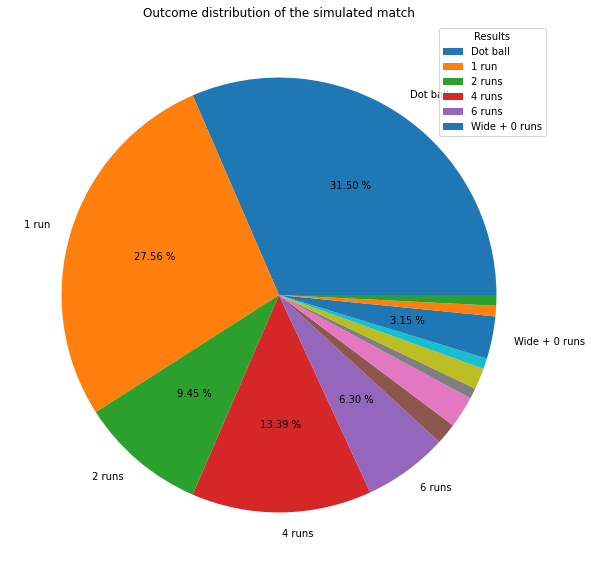

In [5]:
res_dist = {}
tot = inn1.inn_progress_df.shape[0]
for res in (inn1.inn_progress_df["result"]):
    if res in res_dist:
        res_dist[res] += 1
    else:
        res_dist[res] = 1
labels = [res_to_string[i] if res_dist[i]/tot*100 >= thresh else ''
          for i in sorted(res_dist)]
plt.pie([res_dist[i] for i in sorted(res_dist)], labels=labels, autopct=my_autopct)
plt.legend(title = "Results")
plt.title("Outcome distribution of the simulated match")
fig = plt.gcf()
fig.set_size_inches(10, 10)
plt.savefig("Images\\SampleMatch\\inn1_output_distr_runs-190.png", dpi=300)
plt.show()

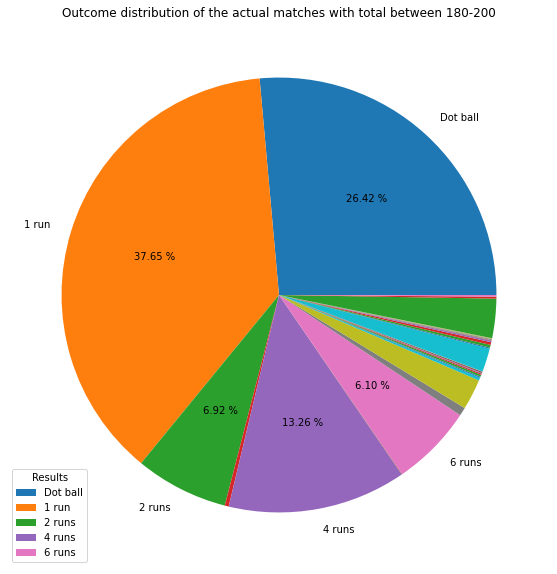

In [9]:
res_dist = {}
score = target - 1
start_score = score - 10
end_score = score + 10
df = batting_first[batting_first["Total"] >= start_score]
df = df[df["Total"] <= end_score]
tot = df.shape[0]
for res in (df["Result"]):
    if res in res_dist:
        res_dist[res] += 1
    else:
        res_dist[res] = 1
labels = [res_to_string[i] if res_dist[i]/tot*100 >= thresh else ''
          for i in sorted(res_dist)]
plt.pie([res_dist[i] for i in sorted(res_dist)], labels=labels, autopct=my_autopct)
plt.title(f"Outcome distribution of the actual matches with total between {start_score}-{end_score}")
plt.legend(title = "Results")
fig = plt.gcf()
fig.set_size_inches(10, 10)
plt.savefig("Images\\SampleMatch\\inn1_output_distr_actual_runs-180to200.png", dpi=300)
plt.show()


In [10]:
progress_df_inn1 = inn1.inn_progress_df
over_progress_inn1 = inn1.Overs_Summary
scores = [i[2] for i in over_progress_inn1]
rrs = [val[2]/(i+1) for i, val in enumerate(over_progress_inn1)]
runs_in_over = [i[0] for i in over_progress_inn1]
fow = [i[1] for i in over_progress_inn1]
phases_data= {}
pp_overs = np.array(over_progress_inn1[:6])
mid_overs = np.array(over_progress_inn1[6:15])
death_overs = np.array(over_progress_inn1[15:])
phases_data['pp_overs'] ={}
phases_data['mid_overs'] ={}
phases_data['death_overs'] ={}

phases_data['pp_overs']['rr'] = np.sum(pp_overs[:, 0]) / pp_overs.shape[0]
phases_data['mid_overs']['rr'] = np.sum(mid_overs[:, 0])/ mid_overs.shape[0]
phases_data['death_overs']['rr'] = np.sum(death_overs[:, 0]) / death_overs.shape[0]

phases_data['pp_overs']['runs'] = np.sum(pp_overs[:, 0]) 
phases_data['mid_overs']['runs'] = np.sum(mid_overs[:, 0])
phases_data['death_overs']['runs'] = np.sum(death_overs[:, 0]) 

phases_data['pp_overs']['wickets'] = np.sum(pp_overs[:, 1])
phases_data['mid_overs']['wickets'] = np.sum(mid_overs[:, 1])
phases_data['death_overs']['wickets'] = np.sum(death_overs[:, 1])
wicket_overs = [i for i, j in enumerate(fow) if j > 0]
print(phases_data)

{'pp_overs': {'rr': 8.5, 'runs': 51, 'wickets': 1}, 'mid_overs': {'rr': 7.777777777777778, 'runs': 70, 'wickets': 3}, 'death_overs': {'rr': 13.8, 'runs': 69, 'wickets': 2}}


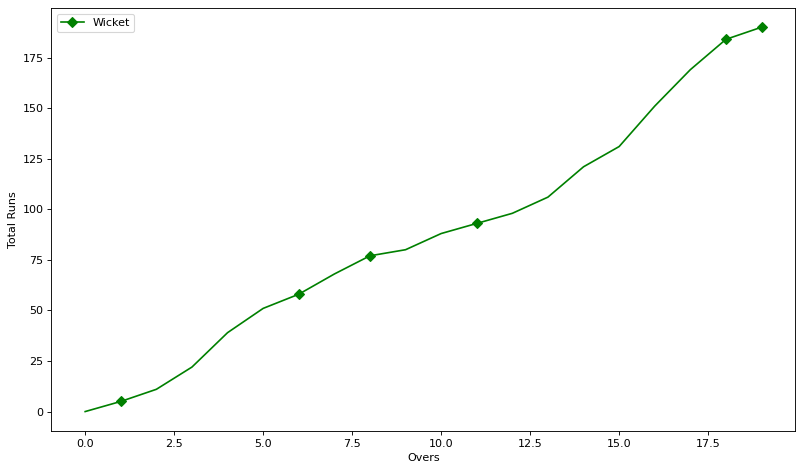

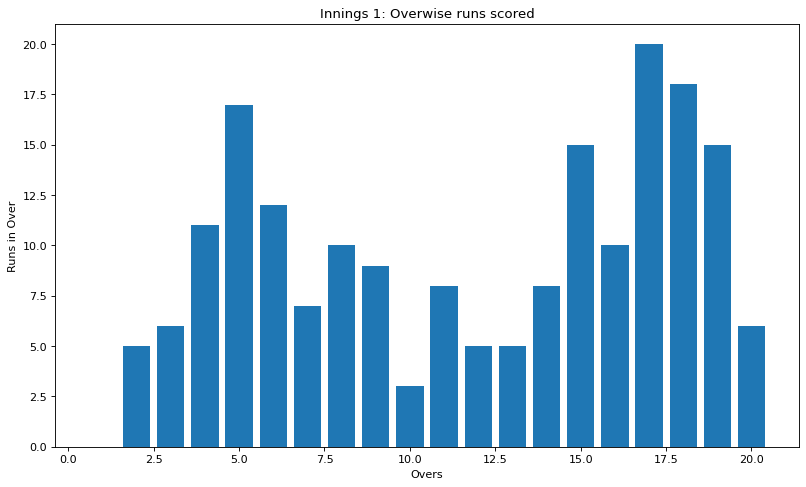

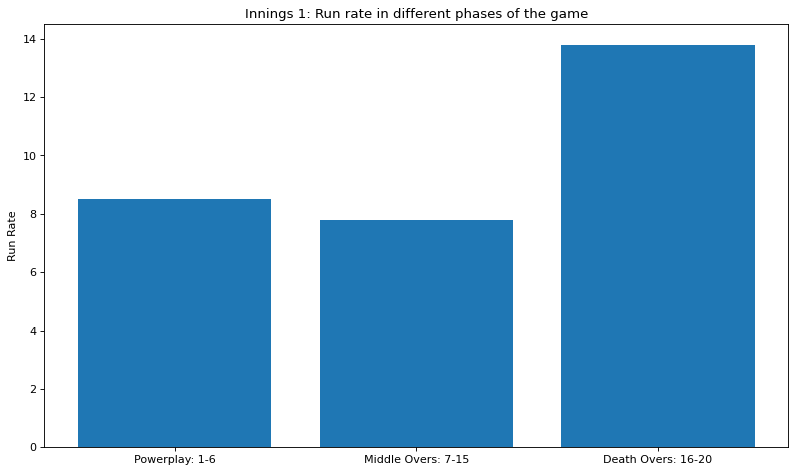

In [11]:
x = [i for i in range(1, 21)]
fig_size = (12, 7)
figure(figsize=fig_size, dpi=80)
plt.plot(scores,'-gD', markevery=wicket_overs, label='Wicket')
plt.legend()
plt.xlabel("Overs")
plt.ylabel("Total Runs")
plt.show()
# figure(figsize=fig_size, dpi=80)
# plt.plot(rrs)
# plt.xlabel("")
# plt.ylabel("")
# plt.show()
figure(figsize=fig_size, dpi=80)
plt.bar(x,runs_in_over)
plt.title("Innings 1: Overwise runs scored")
plt.xlabel("Overs")
plt.ylabel("Runs in Over")
plt.savefig("Images\\SampleMatch\\inn1_overwise_runs_bargraph.png", dpi=300)
plt.show()
figure(figsize=fig_size, dpi=80)
plt.bar(["Powerplay: 1-6", "Middle Overs: 7-15", "Death Overs: 16-20"], [i['rr'] for i in phases_data.values()])
plt.title("Innings 1: Run rate in different phases of the game")
plt.ylabel("Run Rate")
plt.savefig("Images\\SampleMatch\\inn1_phasewise_runrate_bargraph.png", dpi=300)
plt.show()
# figure(figsize=fig_size, dpi=80)
# plt.bar(phases_data.keys(), [i['wickets'] for i in phases_data.values()])
# plt.show()

## Helper to create Pie Chart

In [7]:
chasing = pd.read_csv("Data/Chasing.csv")
ret_chasing = []
prev = tuple([None for i in range(5)])
for ind, row in tqdm(chasing.iterrows(), ncols=80, total=chasing.shape[0]):
    curr = (row["Venue"], row["Batting_Team"], row["Bowling_Team"], row["Toss"], row["Target"])
    if prev != curr:
        ret_chasing.append(curr)
    prev = curr
batting_first = pd.read_csv("Data/Batting_First.csv")
ret_batting_first = []
prev = tuple([None for i in range(4)])
for ind, row in tqdm(batting_first.iterrows(), ncols=80, total=batting_first.shape[0]):
    curr = (row["Venue"], row["Batting_Team"], row["Bowling_Team"], row["Toss"])
    if prev != curr:
        ret_batting_first.append(curr)
    prev = curr
print(len(ret_chasing), len(ret_batting_first))

100%|██████████████████████████████████| 98040/98040 [00:05<00:00, 17507.77it/s]

795 797


In [8]:
bf_count = 0
bs_count = 0
total = []
while bf_count < len(ret_batting_first) and bs_count < len(ret_chasing):
    i = ret_batting_first[bf_count]
    j = ret_chasing[bs_count]
    if i[0] == j[0] and i[1] == j[2] and i[2] == j[1] and i[3] == j[3]:
        bf_count += 1
        bs_count += 1
        total.append(j[4] - 1)
    else:
        bf_count += 1
        total.append(-1)
print(bf_count, bs_count)
target_col = []
prev = None
match_count = -1
for ind, row in tqdm(batting_first.iterrows(), ncols=80, total=batting_first.shape[0]):
    curr = (row["Venue"], row["Batting_Team"], row["Bowling_Team"], row["Toss"])
    if prev != curr:
        match_count += 1
    target_col.append(total[match_count])
    prev = curr
batting_first["Total"] = target_col

797 795


100%|██████████████████████████████████| 98040/98040 [00:05<00:00, 17638.35it/s]


## Innings 2 for paper

In [17]:
# load = "win"
# load = "lose"
load = None
inn2_df = pd.DataFrame(columns=BS_Cols)
with open(f"Evaluation/temp_inn2.pkl", "rb") as fp:
    inn2 = pickle.load(fp)["inn2"]
display_batting_table(inn2)

Chennai Super Kings  :  181 / 5  in  20 . 0
Extras: 6



,Batsman,Runs,Fours,Sixes,Balls Faced,Dismissal Type,Dismissed By
0,SR Watson,36,7,0,21,Caught,N Saini
1,F du Plessis,4,1,0,3,Caught,Mohammed Siraj
2,SK Raina,73,7,3,44,Caught,UT Yadav
3,AT Rayudu,4,0,0,8,Run Out,-
4,KM Jadhav,33,3,1,27,Caught,C de Grandhomme
5,MS Dhoni,12,1,0,9,Not Out,-
6,RA Jadeja,13,2,0,8,Not Out,-
7,DJ Bravo,-,-,-,-,-,-
8,SN Thakur,-,-,-,-,-,-
9,DL Chahar,-,-,-,-,-,-


,Bowler,Runs Conceded,Wickets Taken,Overs,Batsman Names
0,C de Grandhomme,28,1,4.0,KM Jadhav
1,N Saini,25,1,4.0,SR Watson
2,Mohammed Siraj,43,1,4.0,F du Plessis
3,UT Yadav,45,1,4.0,SK Raina
4,YS Chahal,38,0,4.0,-


,Dismissed Batsman,Team Runs,Overs
1,F du Plessis,5,1
0,SR Watson,68,6
3,AT Rayudu,81,9
4,KM Jadhav,155,17
2,SK Raina,155,18


,Over,Bowler,Runs Conceded,Wickets Taken,Total Score,Total Wickets
0,1,Mohammed Siraj,5,1,5,1
1,2,UT Yadav,17,0,22,1
2,3,Mohammed Siraj,15,0,37,1
3,4,UT Yadav,11,0,48,1
4,5,C de Grandhomme,14,0,62,1
5,6,N Saini,6,1,68,2
6,7,C de Grandhomme,4,0,72,2
7,8,YS Chahal,8,0,80,2
8,9,N Saini,6,1,86,3
9,10,YS Chahal,6,0,92,3


In [27]:
# save_evaluator = {}
# save_evaluator["inn2"] = inn2
# with open('Evaluation/win_inn2.pkl', "wb") as fp:
#     pickle.dump(save_evaluator, fp)
# save_evaluator = {}
# save_evaluator["inn2"] = inn2
# with open('Evaluation/temp_inn2.pkl', "wb") as fp:
#     pickle.dump(save_evaluator, fp)

In [18]:
progress_df_inn2 = inn2.inn_progress_df
over_progress_inn2 = inn2.Overs_Summary
scores_2 = [i[2] for i in over_progress_inn2]
rrs_2 = [val[2]/(i+1) for i, val in enumerate(over_progress_inn2)]
runs_in_over_2 = [i[0] for i in over_progress_inn2]
fow_2 = [i[1] for i in over_progress_inn2]
phases_data_2 = {}
pp_overs_2 = np.array(over_progress_inn2[:6])
mid_overs_2 = np.array(over_progress_inn2[6:15])
death_overs_2 = np.array(over_progress_inn2[15:])
phases_data_2['pp_overs'] ={}
phases_data_2['mid_overs'] ={}
phases_data_2['death_overs'] ={}

phases_data_2['pp_overs']['rr'] = np.sum(pp_overs_2[:, 0]) / pp_overs_2.shape[0]
phases_data_2['mid_overs']['rr'] = np.sum(mid_overs_2[:, 0])/ mid_overs_2.shape[0]
phases_data_2['death_overs']['rr'] = np.sum(death_overs[:, 0]) / death_overs.shape[0]

phases_data_2['pp_overs']['runs'] = np.sum(pp_overs_2[:, 0]) 
phases_data_2['mid_overs']['runs'] = np.sum(mid_overs_2[:, 0])
phases_data_2['death_overs']['runs'] = np.sum(death_overs[:, 0]) 

phases_data_2['pp_overs']['wickets'] = np.sum(pp_overs_2[:, 1])
phases_data_2['mid_overs']['wickets'] = np.sum(mid_overs_2[:, 1])
phases_data_2['death_overs']['wickets'] = np.sum(death_overs[:, 1])
wicket_overs_2 = [i for i, j in enumerate(fow_2) if j > 0]
print(phases_data_2)

{'pp_overs': {'rr': 11.333333333333334, 'runs': 68, 'wickets': 2}, 'mid_overs': {'rr': 8.222222222222221, 'runs': 74, 'wickets': 1}, 'death_overs': {'rr': 13.8, 'runs': 69, 'wickets': 2}}


In [19]:
# scores_2.append(inn2.Runs)

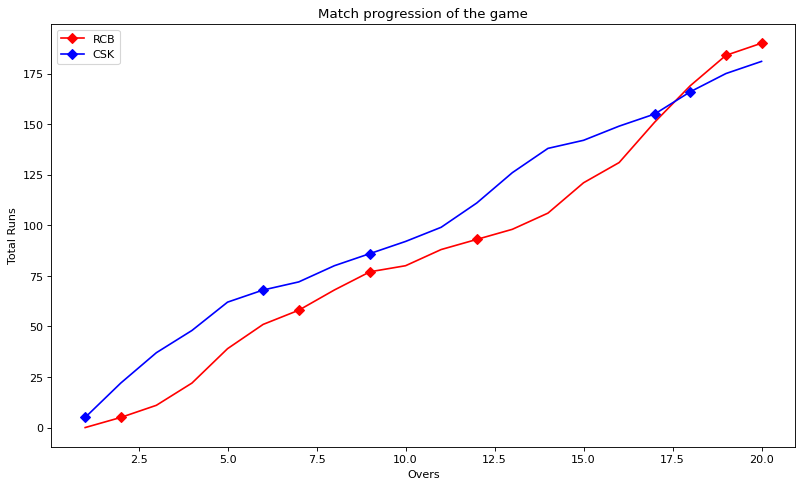

In [21]:
fig_size = (12, 7)
win_or_lose_phrase = "the unsuccessful chase" if load == "lose" else "the successful chase"
if load == None:
    win_or_lose_phrase = "the game"
figure(figsize=fig_size, dpi=80)
plt.plot(list(range(1, len(scores)+1)), scores,'-rD', markevery=wicket_overs, label='RCB')
plt.plot(list(range(1, len(scores_2)+1)), scores_2,'-bD', markevery=wicket_overs_2, label='CSK')
plt.title(f"Match progression of {win_or_lose_phrase}")
plt.legend()
plt.xlabel("Overs")
plt.ylabel("Total Runs")
plt.savefig("Images\\SampleMatch\\inn2_lose_progression.png", dpi=300)
plt.show()

In [31]:
temp = inn2.inn_progress_df.copy(deep=True)
results_text = [res_to_string[i] for i in temp["result"]]
temp["ResultText"] = results_text

In [38]:
temp[80:]

,score,wickets,overs,balls,free_hit,striker,striker_runs,striker_balls,non_striker,non_striker_runs,non_striker_balls,bowler,bowler_runs,bowler_overs,bowler_balls,bowler_wickets,result,ResultText
80,125,3,13,6,0,SK Raina,59,31,KM Jadhav,19,14,Mohammed Siraj,34,2,5,1,2,1 run
81,126,3,14,1,0,SK Raina,60,32,KM Jadhav,19,14,YS Chahal,26,3,0,0,2,1 run
82,127,3,14,2,0,KM Jadhav,19,14,SK Raina,61,33,YS Chahal,27,3,1,0,5,4 runs
83,131,3,14,3,0,KM Jadhav,23,15,SK Raina,61,33,YS Chahal,31,3,2,0,2,1 run
84,132,3,14,4,0,SK Raina,61,33,KM Jadhav,24,16,YS Chahal,32,3,3,0,2,1 run
85,133,3,14,5,0,KM Jadhav,24,16,SK Raina,62,34,YS Chahal,33,3,4,0,2,1 run
86,134,3,14,6,0,SK Raina,62,34,KM Jadhav,25,17,YS Chahal,34,3,5,0,5,4 runs
87,138,3,15,1,0,KM Jadhav,25,17,SK Raina,66,35,C de Grandhomme,18,2,0,0,1,dot ball
88,138,3,15,2,0,KM Jadhav,25,18,SK Raina,66,35,C de Grandhomme,18,2,1,0,2,1 run
89,139,3,15,3,0,SK Raina,66,35,KM Jadhav,26,19,C de Grandhomme,19,2,2,0,1,dot ball


## Innings 2

In [12]:
for _ in range(10):
    inn2_df = pd.DataFrame(columns=BS_Cols)
    inn2 = Innings(CSK_Squad[0], RCB_Squad[1], RCB_Squad[0][0], CSK_Pitch, 2, inn2_df, 179)
    # inn2 = Innings(RCB_Squad[0], CSK_Squad[1], CSK_Squad[0][0], CSK_Pitch, 2, inn2_df, 209)
    inn2.simulate_inning(model_inn_2)
    display_batting_table(inn2, 0)

Chennai Super Kings  :  182 / 3  in  19 . 1
Extras: 11



,Batsman,Runs,Fours,Sixes,Balls Faced,Dismissal Type,Dismissed By
0,SR Watson,8,1,0,7,Caught,Mohammed Siraj
1,F du Plessis,32,5,0,35,Caught,N Saini
2,SK Raina,82,8,4,46,Caught,Mohammed Siraj
3,AT Rayudu,48,4,3,26,Not Out,-
4,KM Jadhav,1,0,0,1,Not Out,-
5,MS Dhoni,-,-,-,-,-,-
6,RA Jadeja,-,-,-,-,-,-
7,DJ Bravo,-,-,-,-,-,-
8,SN Thakur,-,-,-,-,-,-
9,DL Chahar,-,-,-,-,-,-



Chennai Super Kings  :  160 / 7  in  20 . 0
Extras: 8



,Batsman,Runs,Fours,Sixes,Balls Faced,Dismissal Type,Dismissed By
0,SR Watson,16,2,1,11,Caught,UT Yadav
1,F du Plessis,25,4,0,27,Run Out,-
2,SK Raina,30,3,1,24,Caught,N Saini
3,AT Rayudu,4,1,0,4,Caught,N Saini
4,KM Jadhav,7,1,0,5,Caught,YS Chahal
5,MS Dhoni,0,0,0,1,Caught,YS Chahal
6,RA Jadeja,38,2,2,22,Not Out,-
7,DJ Bravo,15,2,1,7,Retired Hurt,-
8,SN Thakur,17,1,0,19,Not Out,-
9,DL Chahar,-,-,-,-,-,-



Chennai Super Kings  :  180 / 8  in  19 . 3
Extras: 5



,Batsman,Runs,Fours,Sixes,Balls Faced,Dismissal Type,Dismissed By
0,SR Watson,39,4,2,23,Run Out,-
1,F du Plessis,10,1,0,12,Caught,C de Grandhomme
2,SK Raina,5,0,0,7,Caught,YS Chahal
3,AT Rayudu,18,2,0,15,Run Out,-
4,KM Jadhav,28,3,0,23,Caught,N Saini
5,MS Dhoni,29,0,3,16,Caught,N Saini
6,RA Jadeja,5,1,0,4,Caught,UT Yadav
7,DJ Bravo,13,1,0,7,Caught,Mohammed Siraj
8,SN Thakur,22,4,0,10,Not Out,-
9,DL Chahar,6,0,1,1,Not Out,-



Chennai Super Kings  :  139 / 2  in  20 . 0
Extras: 7



,Batsman,Runs,Fours,Sixes,Balls Faced,Dismissal Type,Dismissed By
0,SR Watson,83,7,3,61,Not Out,-
1,F du Plessis,1,0,0,7,Caught,Mohammed Siraj
2,SK Raina,25,3,0,30,Caught,YS Chahal
3,AT Rayudu,23,0,0,22,Not Out,-
4,KM Jadhav,-,-,-,-,-,-
5,MS Dhoni,-,-,-,-,-,-
6,RA Jadeja,-,-,-,-,-,-
7,DJ Bravo,-,-,-,-,-,-
8,SN Thakur,-,-,-,-,-,-
9,DL Chahar,-,-,-,-,-,-



Chennai Super Kings  :  180 / 5  in  20 . 0
Extras: 9



,Batsman,Runs,Fours,Sixes,Balls Faced,Dismissal Type,Dismissed By
0,SR Watson,87,8,5,55,Bowled,UT Yadav
1,F du Plessis,0,0,0,2,Caught,Mohammed Siraj
2,SK Raina,23,2,1,12,Caught,N Saini
3,AT Rayudu,13,0,2,7,Run Out,-
4,KM Jadhav,35,3,1,33,Caught,C de Grandhomme
5,MS Dhoni,11,1,0,9,Not Out,-
6,RA Jadeja,2,0,0,1,Not Out,-
7,DJ Bravo,-,-,-,-,-,-
8,SN Thakur,-,-,-,-,-,-
9,DL Chahar,-,-,-,-,-,-



Chennai Super Kings  :  165 / 7  in  20 . 0
Extras: 4



,Batsman,Runs,Fours,Sixes,Balls Faced,Dismissal Type,Dismissed By
0,SR Watson,1,0,0,2,Caught,UT Yadav
1,F du Plessis,9,1,0,15,Caught,UT Yadav
2,SK Raina,39,4,1,37,Caught,N Saini
3,AT Rayudu,16,2,0,13,Bowled,YS Chahal
4,KM Jadhav,13,3,0,5,Caught,N Saini
5,MS Dhoni,54,6,2,29,Caught,UT Yadav
6,RA Jadeja,4,1,0,2,Caught,C de Grandhomme
7,DJ Bravo,16,3,0,11,Not Out,-
8,SN Thakur,9,1,0,6,Not Out,-
9,DL Chahar,-,-,-,-,-,-



Chennai Super Kings  :  170 / 5  in  20 . 0
Extras: 7



,Batsman,Runs,Fours,Sixes,Balls Faced,Dismissal Type,Dismissed By
0,SR Watson,6,1,0,8,Caught,UT Yadav
1,F du Plessis,15,2,0,16,Caught,N Saini
2,SK Raina,16,2,1,9,Caught,UT Yadav
3,AT Rayudu,9,1,0,7,Caught,C de Grandhomme
4,KM Jadhav,3,0,0,7,Bowled,N Saini
5,MS Dhoni,50,3,2,38,Not Out,-
6,RA Jadeja,64,7,2,35,Not Out,-
7,DJ Bravo,-,-,-,-,-,-
8,SN Thakur,-,-,-,-,-,-
9,DL Chahar,-,-,-,-,-,-



Chennai Super Kings  :  181 / 4  in  17 . 3
Extras: 9



,Batsman,Runs,Fours,Sixes,Balls Faced,Dismissal Type,Dismissed By
0,SR Watson,8,1,0,6,Bowled,UT Yadav
1,F du Plessis,36,5,1,21,LBW,C de Grandhomme
2,SK Raina,92,10,4,49,Caught,C de Grandhomme
3,AT Rayudu,19,1,2,15,Caught,N Saini
4,KM Jadhav,16,3,0,15,Not Out,-
5,MS Dhoni,1,0,0,2,Not Out,-
6,RA Jadeja,-,-,-,-,-,-
7,DJ Bravo,-,-,-,-,-,-
8,SN Thakur,-,-,-,-,-,-
9,DL Chahar,-,-,-,-,-,-



Chennai Super Kings  :  155 / 6  in  20 . 0
Extras: 8



,Batsman,Runs,Fours,Sixes,Balls Faced,Dismissal Type,Dismissed By
0,SR Watson,7,1,0,7,Caught,Mohammed Siraj
1,F du Plessis,4,0,0,10,Bowled,UT Yadav
2,SK Raina,16,1,1,15,Caught,C de Grandhomme
3,AT Rayudu,49,5,2,30,Caught,C de Grandhomme
4,KM Jadhav,44,2,2,36,Not Out,-
5,MS Dhoni,0,0,0,1,Caught,C de Grandhomme
6,RA Jadeja,21,1,1,15,Caught,Mohammed Siraj
7,DJ Bravo,6,0,0,6,Not Out,-
8,SN Thakur,-,-,-,-,-,-
9,DL Chahar,-,-,-,-,-,-



Chennai Super Kings  :  164 / 7  in  20 . 0
Extras: 5



,Batsman,Runs,Fours,Sixes,Balls Faced,Dismissal Type,Dismissed By
0,SR Watson,45,7,0,35,Caught,YS Chahal
1,F du Plessis,26,2,1,23,Caught,N Saini
2,SK Raina,0,0,0,0,Run Out,-
3,AT Rayudu,17,2,1,9,LBW,N Saini
4,KM Jadhav,12,0,1,9,Caught,C de Grandhomme
5,MS Dhoni,42,5,1,28,Caught,UT Yadav
6,RA Jadeja,11,1,0,12,Caught,UT Yadav
7,DJ Bravo,1,0,0,1,Not Out,-
8,SN Thakur,5,1,0,3,Not Out,-
9,DL Chahar,-,-,-,-,-,-


## Simulating Matches

In [30]:
print("Simulating First Match")
match_sim2 = Match(RCB_Squad, MI_Squad, RCB_Pitch, model_inn_1, model_inn_2, Display=1)

Simulating First Match
Royal Challengers Bangalore won the toss and chose to Bat first
Royal Challengers Bangalore  :  174 / 7  in  20 . 0
Extras: 14



,Batsman,Runs,Fours,Sixes,Balls Faced,Dismissal Type,Dismissed By
0,PA Patel,100,5,7,62,Bowled,SL Malinga
1,V Kohli,5,1,0,8,LBW,SL Malinga
2,AB de Villiers,2,0,0,6,Caught,SL Malinga
3,M Ali,2,0,0,5,Caught,JJ Bumrah
4,S Hetmyer,17,1,0,19,Caught,SL Malinga
5,S Dube,10,2,0,6,Caught,J Behrendorff
6,C de Grandhomme,16,0,1,10,Not Out,-
7,N Saini,2,0,0,2,Caught,JJ Bumrah
8,YS Chahal,6,1,0,4,Not Out,-
9,UT Yadav,-,-,-,-,-,-



Mumbai Indians  :  151 / 5  in  20 . 0
Extras: 6



,Batsman,Runs,Fours,Sixes,Balls Faced,Dismissal Type,Dismissed By
0,Q de Kock,39,8,0,19,Run Out,-
1,RG Sharma,24,1,0,32,Caught,Mohammed Siraj
2,SA Yadav,59,5,3,34,Bowled,N Saini
3,Ishan Kishan,1,0,0,2,Bowled,Mohammed Siraj
4,HH Pandya,12,0,0,21,Not Out,-
5,KA Pollard,7,1,0,7,LBW,UT Yadav
6,KH Pandya,3,0,0,6,Not Out,-
7,RD Chahar,-,-,-,-,-,-
8,J Behrendorff,-,-,-,-,-,-
9,JJ Bumrah,-,-,-,-,-,-



Royal Challengers Bangalore won by 23 Runs
